In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from tqdm import tqdm
import datetime

from keras.layers import BatchNormalization, Dropout, LSTM, Dense, Flatten, MaxPooling1D
from keras.layers import ConvLSTM2D, Input, Conv1D, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD

from keras.layers import Flatten, MaxPooling1D

from keras.callbacks import EarlyStopping


import tensorflow as tf


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Historical_Wildfires.csv
For now, I will isolate the y_target, 'Estimated_fire_area' in order to see how many missing values we have on our dependant variable.

In [177]:
regions = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']

merge_df = pd.DataFrame(index = range(5783))

for each in regions:
    df = pd.read_csv('{}_iso.csv'.format(each))
    df.drop(columns = ['Date'], inplace=True)

                        
#     for i in df.columns:
#         df[i] = df[i].fillna(method='ffill')
    
    merge_df = pd.concat([merge_df, df], axis = 1)


In [178]:
merge_df

,Estimated_fire_area_NSW,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,mean_SoilWaterContent_NSW,mean_SolarRadiation_NSW,mean_Temperature_NSW,mean_WindSpeed_NSW,Vegetation_index_mean_NSW,Estimated_fire_area_NT,...,Vegetation_index_mean_VI,Estimated_fire_area_WA,Count_WA,mean_Precipitation_WA,mean_RelativeHumidity_WA,mean_SoilWaterContent_WA,mean_SolarRadiation_WA,mean_Temperature_WA,mean_WindSpeed_WA,Vegetation_index_mean_WA
0,0.000000,0.0,0.044274,36.355567,0.170931,26.749389,27.341182,3.323550,0.352505,4.945,...,0.480638,36.382500,16.0,1.872415,49.027855,0.075728,26.967495,28.524055,4.201039,0.212803
1,0.000000,0.0,0.173879,38.699607,0.169551,27.047523,26.143898,3.030897,0.352165,1.320,...,0.479460,148.106471,34.0,2.110536,45.840524,0.079449,26.776612,28.695349,4.650767,0.213312
2,0.000000,0.0,3.011912,49.365152,0.179981,24.197452,27.408810,3.958409,0.351915,88.740,...,0.478463,60.632258,31.0,0.851700,39.740976,0.076233,28.656122,27.650498,5.216546,0.213799
3,8.680000,3.0,2.808620,57.095628,0.214293,22.617291,23.055527,4.841764,0.351657,0.000,...,0.477542,86.374167,36.0,0.155206,36.538677,0.067969,29.868001,27.421797,4.850140,0.214283
4,16.611250,8.0,0.157935,47.170735,0.203951,28.076835,22.425765,4.014080,0.351441,0.000,...,0.476780,31.378947,19.0,0.061034,33.564562,0.061579,30.280623,28.159704,4.464719,0.214747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,NaN,112.794545,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5848,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,NaN,34.222222,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5849,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,NaN,26.248000,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5850,1.320000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,NaN,17.887500,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
fire_regions = ['Estimated_fire_area_{}'.format(i) for i in regions]
count_regions = ['Count_{}'.format(i) for i in regions]
sqrt_fire_regions = ['sqrt_{}'.format(i) for i in fire_regions]
sqrt_count_regions = ['sqrt_Count_{}'.format(i) for i in regions]

merge_df = pd.concat([merge_df[fire_regions], merge_df.drop(columns = fire_regions)], axis =1)
merge_df['Date'] = pd.date_range(start = '2005-01-01', end = '2021-01-08')
merge_df.set_index('Date', inplace=True)

for i,x in zip(fire_regions, count_regions):
    merge_df['sqrt_{}'.format(i)] = np.sqrt(merge_df[i])
    merge_df['sqrt_{}'.format(x)] = np.sqrt(merge_df[i]/merge_df[x]) * merge_df[x]
    
# merge_df.fillna(0, inplace=True)



In [180]:
merge_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.000000,4.945,38.831579,0.0,0.0,0.0,36.382500,0.0,0.044274,36.355567,...,6.231499,27.162474,0.000000,NaN,0.0,NaN,0.00000,NaN,6.031791,24.127163
2005-01-02,0.000000,1.320,64.464286,0.0,0.0,2.8,148.106471,0.0,0.173879,38.699607,...,8.028965,42.485292,0.000000,NaN,0.0,NaN,1.67332,1.67332,12.169900,70.962103
2005-01-03,0.000000,88.740,47.386585,0.0,0.0,1.0,60.632258,0.0,3.011912,49.365152,...,6.883791,44.077772,0.000000,NaN,0.0,NaN,1.00000,1.00000,7.786672,43.354354
2005-01-04,8.680000,0.000,30.100000,0.0,0.0,0.0,86.374167,3.0,2.808620,57.095628,...,5.486347,26.877500,0.000000,NaN,0.0,NaN,0.00000,NaN,9.293770,55.762622
2005-01-05,16.611250,0.000,4.000000,0.0,0.0,0.0,31.378947,8.0,0.157935,47.170735,...,2.000000,4.000000,0.000000,NaN,0.0,NaN,0.00000,NaN,5.601691,24.417207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-04,0.000000,0.000,1.000000,0.0,0.0,0.0,112.794545,0.0,NaN,NaN,...,1.000000,1.000000,0.000000,NaN,0.0,NaN,0.00000,NaN,10.620478,78.763570
2021-01-05,0.000000,0.000,2.080000,0.0,0.0,0.0,34.222222,0.0,NaN,NaN,...,1.442221,1.442221,0.000000,NaN,0.0,NaN,0.00000,NaN,5.849976,24.819347
2021-01-06,0.000000,0.000,14.541818,0.0,0.0,0.0,26.248000,0.0,NaN,NaN,...,3.813374,12.647529,0.000000,NaN,0.0,NaN,0.00000,NaN,5.123280,16.201235


In [181]:
merge_df = merge_df[:'2021-01-02']

In [182]:
merge_df.isna().sum()

Estimated_fire_area_NSW           0
Estimated_fire_area_NT            0
Estimated_fire_area_QL            0
Estimated_fire_area_SA            0
Estimated_fire_area_TA            0
                               ... 
sqrt_Count_TA                  4428
sqrt_Estimated_fire_area_VI       0
sqrt_Count_VI                  3657
sqrt_Estimated_fire_area_WA       0
sqrt_Count_WA                   159
Length: 77, dtype: int64

In [183]:
merge_df.fillna(0, inplace=True)

C:\Users\albert\Anaconda3\lib\site-packages\pandas\core\frame.py:4465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [184]:
merge_df = pd.concat([merge_df[fire_regions], merge_df.drop(columns = fire_regions)], axis =1)

In [185]:
merge_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.00000,4.945,38.831579,0.0,0.0,0.0,36.382500,0.0,0.044274,36.355567,...,6.231499,27.162474,0.0,0.0,0.0,0.0,0.00000,0.00000,6.031791,24.127163
2005-01-02,0.00000,1.320,64.464286,0.0,0.0,2.8,148.106471,0.0,0.173879,38.699607,...,8.028965,42.485292,0.0,0.0,0.0,0.0,1.67332,1.67332,12.169900,70.962103
2005-01-03,0.00000,88.740,47.386585,0.0,0.0,1.0,60.632258,0.0,3.011912,49.365152,...,6.883791,44.077772,0.0,0.0,0.0,0.0,1.00000,1.00000,7.786672,43.354354
2005-01-04,8.68000,0.000,30.100000,0.0,0.0,0.0,86.374167,3.0,2.808620,57.095628,...,5.486347,26.877500,0.0,0.0,0.0,0.0,0.00000,0.00000,9.293770,55.762622
2005-01-05,16.61125,0.000,4.000000,0.0,0.0,0.0,31.378947,8.0,0.157935,47.170735,...,2.000000,4.000000,0.0,0.0,0.0,0.0,0.00000,0.00000,5.601691,24.417207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-29,8.40000,0.000,2.200000,0.0,0.0,0.0,10.495714,3.0,3.846753,53.935486,...,1.483240,2.097618,0.0,0.0,0.0,0.0,0.00000,0.00000,3.239709,8.571464
2020-12-30,0.00000,0.000,7.392000,0.0,0.0,0.0,16.560000,0.0,0.915799,52.785360,...,2.718823,6.079474,0.0,0.0,0.0,0.0,0.00000,0.00000,4.069398,12.868566
2020-12-31,0.00000,0.000,3.200000,0.0,0.0,0.0,10.800000,0.0,2.778156,61.837165,...,1.788854,3.098387,0.0,0.0,0.0,0.0,0.00000,0.00000,3.286335,6.572671


In [217]:
for i in fire_regions + count_regions + sqrt_fire_regions + sqrt_count_regions:
    merge_df[i] = np.log1p(merge_df[i])

In [218]:
train = merge_df[:'2020-12-01']
test = merge_df['2020-12-01':]

In [219]:
test.shape

(33, 77)

In [220]:

tf.keras.backend.clear_session()

In [221]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(train)
_train = scaler.transform(train)
_train.shape

(5814, 77)

In [222]:

def split_sequence(sequences, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(0, len(sequences), 1):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix, :]
        seq_y = sequences[end_ix:out_end_ix, :7]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [223]:
n_steps_in, n_steps_out = 50, 20

In [224]:
X, y = split_sequence(_train, n_steps_in, n_steps_out)
y.shape

(5745, 20, 7)

In [225]:
X.shape

(5745, 50, 77)

In [226]:
# from sklearn.utils import shuffle
# X, y = shuffle(X, y)

In [227]:
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
n_features = X.shape[2]

In [228]:
y.shape

(5745, 140)

In [229]:
n_output

140

In [230]:
X_train, y_train = X[:-365,:,:], y[:-365,:]
X_valid, y_valid = X[-365:, :, :], y[-365:, :]

In [231]:

n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
# history_seq = Input(shape =(n_steps_in, n_features))
history_seq = Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)

    
    # residual connection
    x = Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)
pred_seq_train = Dense(n_output, activation = 'relu')(out)

model = Model(history_seq, pred_seq_train)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr = 1e-6)

model.compile(optimizer, loss= tf.keras.losses.Poisson(), metrics = ['mae'])

In [99]:
history = model.fit(X_train, y_train, epochs = 100, callbacks = [lr_schedule], validation_data = (X_valid, y_valid))

Epoch 1/100
151/151 [==============================] - 13s 85ms/step - loss: 2.8052 - mae: 0.2761 - val_loss: 3.2244 - val_mae: 0.3140
Epoch 2/100
151/151 [==============================] - 11s 74ms/step - loss: 2.7820 - mae: 0.2759 - val_loss: 3.1963 - val_mae: 0.3138
Epoch 3/100
151/151 [==============================] - 12s 82ms/step - loss: 2.7638 - mae: 0.2756 - val_loss: 3.1703 - val_mae: 0.3135
Epoch 4/100
 18/151 [==>...........................] - ETA: 9s - loss: 2.7480 - mae: 0.2750

KeyboardInterrupt: 

In [359]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-1, 0, .5]);

KeyError: 'lr'

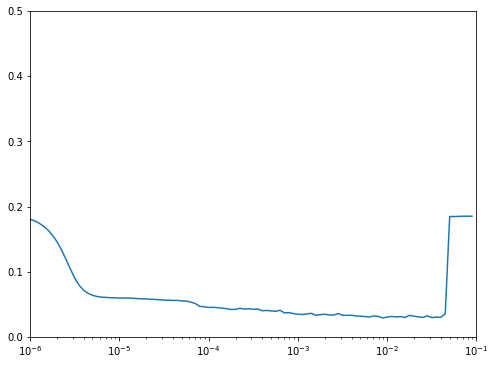

In [355]:
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([1e-6, 1e-1, 0, .5]);

In [232]:

n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
# history_seq = Input(shape =(n_steps_in, n_features))
history_seq = Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    
    # residual connection
    x = Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))


# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)

out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)


pred_seq_train = Dense(n_output, activation = 'relu')(out)
model = Model(history_seq, pred_seq_train)


optimizer = tf.keras.optimizers.Adam(lr = 1e-4
                                    )

# tf.keras.losses.Poisson()
model.compile(optimizer, loss=tf.keras.losses.Poisson(), metrics = ['mae'])

In [233]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_valid, y_valid))

Epoch 1/100
169/169 [==============================] - 14s 85ms/step - loss: 2.0919 - mae: 0.2354 - val_loss: 1.5556 - val_mae: 0.2082
Epoch 2/100
169/169 [==============================] - 13s 75ms/step - loss: 1.6359 - mae: 0.2155 - val_loss: 1.3717 - val_mae: 0.1997
Epoch 3/100
169/169 [==============================] - 13s 75ms/step - loss: 1.4797 - mae: 0.2074 - val_loss: 1.3459 - val_mae: 0.1964
Epoch 4/100
169/169 [==============================] - 13s 75ms/step - loss: 1.4407 - mae: 0.2046 - val_loss: 1.3144 - val_mae: 0.1939
Epoch 5/100
169/169 [==============================] - 13s 75ms/step - loss: 1.4209 - mae: 0.2007 - val_loss: 1.3016 - val_mae: 0.1911
Epoch 6/100
169/169 [==============================] - 13s 76ms/step - loss: 1.4064 - mae: 0.1981 - val_loss: 1.3010 - val_mae: 0.1901
Epoch 7/100
169/169 [==============================] - 13s 78ms/step - loss: 1.4031 - mae: 0.1962 - val_loss: 1.3007 - val_mae: 0.1896
Epoch 8/100
169/169 [==============================] - 

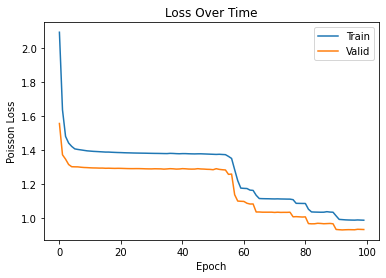

In [234]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Poisson Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [235]:
x_input = np.array(train.iloc[-50:].values)
x_input = scaler.transform(x_input)

x_input = x_input.reshape((1, n_steps_in, n_features))

yhat = model.predict(x_input, verbose=0)
yhat.shape

(1, 140)

In [236]:
yhat_df = pd.DataFrame(yhat.reshape(20,7), index = test[:20].index, columns = fire_regions)

In [237]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
Date,,,,,,,
2020-12-01,0.190596,0.451700,0.554786,0.126374,0.078823,0.109564,0.548241
2020-12-02,0.262206,0.391097,0.548982,0.118734,0.095813,0.145462,0.553001
2020-12-03,0.184271,0.407320,0.539168,0.000000,0.000000,0.114756,0.539691
2020-12-04,0.177101,0.386505,0.500406,0.112579,0.046042,0.149896,0.513868
2020-12-05,0.178875,0.418580,0.541732,0.100320,0.126455,0.000000,0.000000
2020-12-06,0.184655,0.416532,0.540381,0.098672,0.091233,0.085054,0.516033
2020-12-07,0.000000,0.392848,0.542049,0.112888,0.076453,0.120763,0.530748
2020-12-08,0.198699,0.000000,0.526760,0.114006,0.113460,0.000000,0.518151
2020-12-09,0.190848,0.000000,0.514291,0.103591,0.092991,0.000000,0.522425


In [238]:
for i in range(70):
    yhat_df['dummy_{}'.format(i)] = 0
    
_yhat_df = scaler.inverse_transform(yhat_df)

yhat_df = pd.DataFrame(data = _yhat_df,
                      index = yhat_df.index,
                      columns = yhat_df.columns)

In [239]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,dummy_0,dummy_1,dummy_2,...,dummy_60,dummy_61,dummy_62,dummy_63,dummy_64,dummy_65,dummy_66,dummy_67,dummy_68,dummy_69
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,1.630254,4.165784,4.587325,0.936926,0.529690,0.877318,4.957300,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-02,2.242772,3.606874,4.539333,0.880288,0.643860,1.164760,5.000342,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-03,1.576154,3.756493,4.458186,0.000000,0.000000,0.918891,4.879986,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-04,1.514830,3.564531,4.137677,0.834655,0.309399,1.200268,4.646490,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-05,1.530002,3.860334,4.479387,0.743767,0.849773,0.000000,0.000000,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-06,1.579444,3.841451,4.468223,0.731549,0.613084,0.681052,4.666066,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-07,0.000000,3.623022,4.482008,0.836946,0.513763,0.966986,4.799130,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-08,1.699562,0.000000,4.355587,0.845236,0.762449,0.000000,4.685221,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-09,1.632413,0.000000,4.252491,0.768019,0.624894,0.000000,4.723865,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [240]:
test[:20]

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,0.000000,3.952441,5.482567,0.0,0.000000,0.000000,2.940440,0.000000,0.206143,39.675256,...,2.801820,5.159120,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.655117,2.751489
2020-12-02,0.000000,3.344980,5.793518,0.0,0.000000,0.000000,4.767425,0.000000,1.029015,42.126130,...,2.949045,5.588928,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.468005,4.395519
2020-12-03,1.071584,0.741937,5.230254,0.0,0.000000,0.000000,3.305879,0.693147,2.246048,46.104476,...,2.683233,4.907220,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.812488,3.068178
2020-12-04,1.798404,2.091041,6.379596,0.0,0.000000,1.526056,2.840247,1.386294,0.425724,35.201274,...,3.229338,5.960199,0.0,0.0,0.000000,0.000000,1.063802,1.303804,1.612428,2.661389
2020-12-05,0.693147,2.325325,6.154903,0.0,0.000000,0.000000,3.068983,0.693147,5.091297,61.585253,...,3.121482,5.979980,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.710170,2.680316
2020-12-06,0.000000,3.091529,6.331382,0.0,0.000000,0.000000,3.074117,0.000000,0.224302,43.849043,...,3.206156,5.945835,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.712375,2.855137
2020-12-07,1.321756,2.398804,5.910069,0.0,0.000000,0.000000,3.444595,1.098612,0.667009,47.497153,...,3.004510,5.673978,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.872928,3.165782
2020-12-08,3.069912,3.806151,6.018555,0.0,0.000000,0.000000,1.945910,2.302585,0.012537,42.210711,...,3.056266,5.475882,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.238226,1.945910
2020-12-09,1.996060,3.227637,5.620567,0.0,0.000000,0.000000,1.098612,1.791759,0.034324,39.774069,...,2.867018,5.383901,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.881374,1.098612


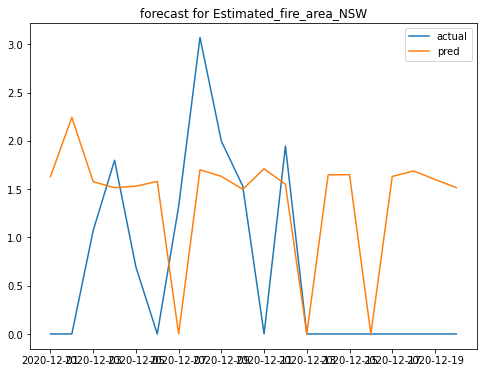

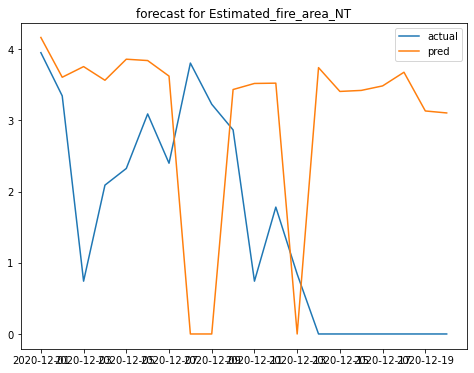

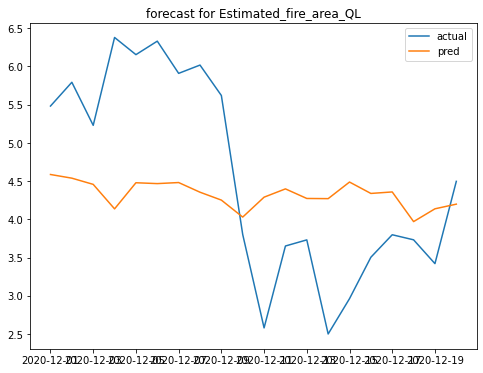

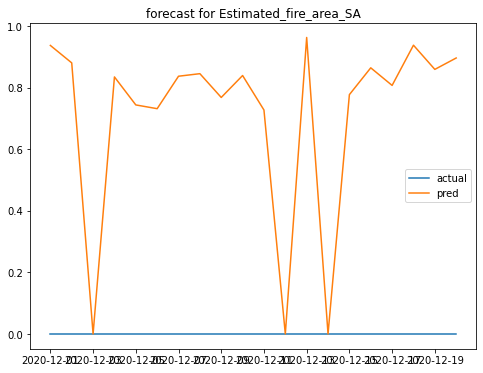

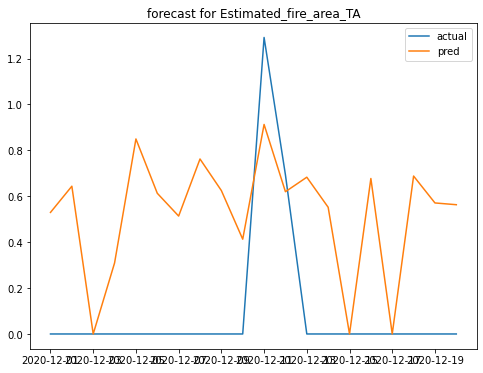

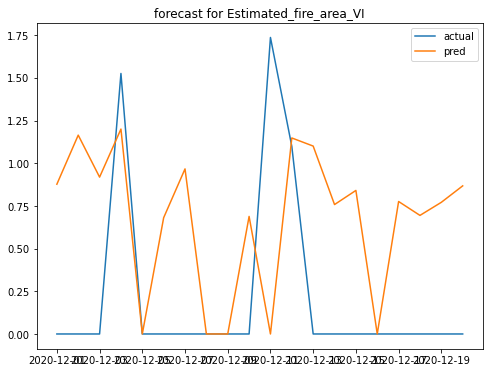

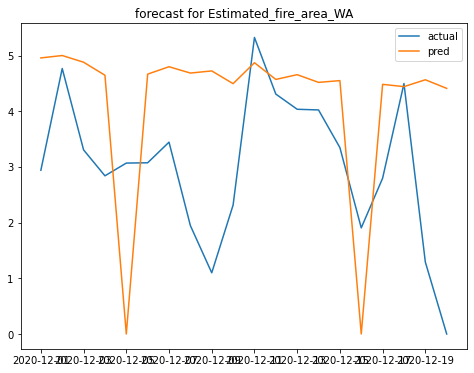

In [241]:
for i in fire_regions:

    plt.figure(figsize=(8,6))
    plt.plot(test[:20][i], label = 'actual')
    plt.plot(yhat_df[i], label ='pred')
    plt.title('forecast for {}'.format(i))
    plt.legend()
    plt.show();

In [242]:
x_input = np.array(merge_df.iloc[-50:].values)
x_input = scaler.transform(x_input)

x_input = x_input.reshape((1, n_steps_in, n_features))

yhat = model.predict(x_input, verbose=0)
yhat.shape

(1, 140)

In [243]:
yhat_df = pd.DataFrame(yhat.reshape(20,7), index = pd.date_range(start = '2021-01-03', end = '2021-01-22'), columns = fire_regions)

In [244]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
2021-01-03,0.111688,0.184898,0.419246,0.047393,0.085609,0.093625,0.368021
2021-01-04,0.228339,0.173253,0.417945,0.032532,0.075231,0.110992,0.405220
2021-01-05,0.112880,0.143414,0.417994,0.000000,0.000000,0.085054,0.386588
2021-01-06,0.073792,0.134802,0.364224,0.034958,0.041039,0.125280,0.373130
2021-01-07,0.095007,0.168472,0.405630,0.017732,0.113322,0.000000,0.000000
2021-01-08,0.122189,0.161572,0.409454,0.041555,0.105983,0.079805,0.339812
2021-01-09,0.000000,0.142310,0.411780,0.050478,0.098893,0.110445,0.326670
2021-01-10,0.122234,0.000000,0.385504,0.036284,0.116413,0.000000,0.349823
2021-01-11,0.099321,0.000000,0.379093,0.065657,0.087493,0.000000,0.339927
2021-01-12,0.104042,0.135447,0.324512,0.030171,0.058341,0.074906,0.318277


In [245]:
for i in range(70):
    yhat_df['dummy_{}'.format(i)] = 0
    
_yhat_df = scaler.inverse_transform(yhat_df)

yhat_df = pd.DataFrame(data = _yhat_df,
                      index = yhat_df.index,
                      columns = yhat_df.columns)

In [246]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,dummy_0,dummy_1,dummy_2,...,dummy_60,dummy_61,dummy_62,dummy_63,dummy_64,dummy_65,dummy_66,dummy_67,dummy_68,dummy_69
2021-01-03,0.955316,1.705219,3.466592,0.351366,0.575291,0.749687,3.327717,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-04,1.953093,1.597820,3.455840,0.241194,0.505551,0.888749,3.664079,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-05,0.965518,1.322628,3.456248,0.000000,0.000000,0.681058,3.495606,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-06,0.631177,1.243205,3.011635,0.259178,0.275783,1.003159,3.373909,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-07,0.812636,1.553727,3.354012,0.131466,0.761521,0.000000,0.000000,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-08,1.045142,1.490093,3.385633,0.308087,0.712205,0.639026,3.072643,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-09,0.000000,1.312445,3.404862,0.374238,0.664555,0.884371,2.953812,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-10,1.045527,0.000000,3.187593,0.269006,0.782289,0.000000,3.163166,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-11,0.849537,0.000000,3.134586,0.486778,0.587950,0.000000,3.073688,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-12,0.889916,1.249158,2.683275,0.223689,0.392051,0.599794,2.877924,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [247]:
submission = yhat_df['2021-01-16':'2021-01-22'][fire_regions]

In [248]:
submission.reset_index()

,index,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
0,2021-01-16,0.930034,1.075286,3.205226,0.000000,0.446688,0.520105,3.102458
1,2021-01-17,0.976643,0.997668,3.056518,0.393599,0.000000,0.819146,3.017194
2,2021-01-18,0.000000,1.120947,3.021916,0.514184,0.881041,0.000000,0.000000
3,2021-01-19,1.185476,1.347226,3.022311,0.363225,0.000000,0.433089,3.000097
4,2021-01-20,1.078846,1.786130,2.720132,0.497813,0.748398,0.489999,3.064304
5,2021-01-21,1.193996,0.943624,2.854153,0.314118,0.502674,0.383999,3.038764
6,2021-01-22,1.110912,2.038110,2.930827,0.357211,0.752676,0.974124,2.821082


In [249]:
submission_df = pd.melt(submission.reset_index().rename(columns={'index':'Date'}), id_vars = 'Date')

In [250]:
submission_df.rename(columns = {'variable': 'Region', 'value': 'Estimated_fire_area'}, inplace=True)
submission_df = pd.concat([submission_df[['Region']], submission_df[['Date']], submission_df['Estimated_fire_area']], axis = 1)

In [251]:
for i,x in zip(fire_regions, regions):
    submission_df['Region'].replace(to_replace = i, value = x, inplace=True)

In [252]:
submission_df['Date'] = submission_df['Date'].dt.strftime('%b-%d')

In [253]:
submission_df['Estimated_fire_area'] = np.exp(submission_df['Estimated_fire_area']) - 1
submission_df

,Region,Date,Estimated_fire_area
0,NSW,Jan-16,1.534594
1,NSW,Jan-17,1.655527
2,NSW,Jan-18,0.000000
3,NSW,Jan-19,2.272245
4,NSW,Jan-20,1.941285
5,NSW,Jan-21,2.300243
6,NSW,Jan-22,2.037126
7,NT,Jan-16,1.930830
8,NT,Jan-17,1.711950
9,NT,Jan-18,2.067757


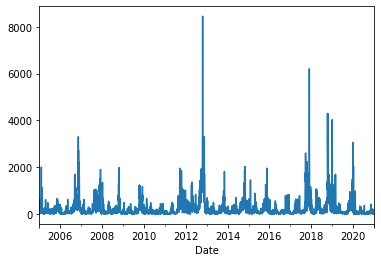

In [175]:
(np.exp(merge_df['Estimated_fire_area_WA']) - 1).plot()

In [255]:
submission_df

,Region,Date,Estimated_fire_area
0,NSW,Jan-16,1.534594
1,NSW,Jan-17,1.655527
2,NSW,Jan-18,0.000000
3,NSW,Jan-19,2.272245
4,NSW,Jan-20,1.941285
5,NSW,Jan-21,2.300243
6,NSW,Jan-22,2.037126
7,NT,Jan-16,1.930830
8,NT,Jan-17,1.711950
9,NT,Jan-18,2.067757


In [256]:
submission_df.to_csv('submissions/week3_dcnn2.csv', index= False, header=True)

In [335]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())

mse = mean_squared_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 38.90290729013289, 'mse': 22997.828797146867}}

In [349]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())

mse = mean_squared_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 37.61219740369566, 'mse': 23569.307062687083}}

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = (np.exp(yhat_df['2020-02':][fire_regions].values)-1).flatten(),
                   y_pred = (np.exp(test['2020-02':][fire_regions].values)-1).flatten())

mse = mean_squared_error(y_true = (np.exp(yhat_df['2020-02':][fire_regions].values)-1).flatten(),
                   y_pred = (np.exp(test['2020-02':][fire_regions].values)-1).flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 32.63632714983575, 'mse': 23245.925698827847}}

In [242]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = np.power(np.exp(yhat_df['2020-02':][sqrt_fire_regions].values)-1, 2).flatten(),
                   y_pred = np.power(np.exp(test['2020-02':][sqrt_fire_regions].values)-1, 2).flatten())

mse = mean_squared_error(y_true = np.power(np.exp(yhat_df['2020-02':][sqrt_fire_regions].values)-1, 2).flatten(),
                   y_pred = np.power(np.exp(test['2020-02':][sqrt_fire_regions].values)-1, 2).flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 32.181879816855414, 'mse': 22984.509506718343}}

In [102]:
_results

{'dcnn_log1p': {'mae': 31.10491818762526, 'mse': 23585.2343689479}}

In [68]:
submission = np.exp(yhat_df['2020-02':'2020-02-28'][fire_regions])-1

In [350]:
submission = yhat_df['2020-02':'2020-02-28'][fire_regions]

In [351]:
submission

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
Date,,,,,,,
2020-02-01,4.872530,16.290304,76.914148,19.893977,0.000000,23.908127,76.084201
2020-02-02,4.025656,23.735369,90.589854,23.487532,11.047121,16.285827,61.459896
2020-02-03,18.506602,51.645641,80.972067,24.013329,5.385706,21.382732,119.708074
2020-02-04,10.369689,48.859950,76.366904,0.000000,6.302943,28.132637,45.278764
2020-02-05,10.350995,17.703335,79.200445,10.995348,5.655730,24.478431,44.870076
2020-02-06,13.065515,50.335522,75.509145,8.041986,4.197926,28.485465,53.816033
2020-02-07,19.344893,0.677286,67.839734,8.646607,0.000000,21.937465,46.250313
2020-02-08,11.768787,48.010576,68.704283,14.024737,0.000000,16.893945,19.844584
2020-02-09,7.614478,0.000000,65.091977,0.000000,6.379442,22.420182,20.294774


In [352]:
submission = pd.melt(submission.reset_index(), id_vars = 'Date')

In [353]:
submission

,Date,variable,value
0,2020-02-01,Estimated_fire_area_NSW,4.872530
1,2020-02-02,Estimated_fire_area_NSW,4.025656
2,2020-02-03,Estimated_fire_area_NSW,18.506602
3,2020-02-04,Estimated_fire_area_NSW,10.369689
4,2020-02-05,Estimated_fire_area_NSW,10.350995
...,...,...,...
191,2020-02-24,Estimated_fire_area_WA,52.541951
192,2020-02-25,Estimated_fire_area_WA,52.417119
193,2020-02-26,Estimated_fire_area_WA,47.690596
194,2020-02-27,Estimated_fire_area_WA,49.066346


In [354]:
submission.rename(columns = {'variable': 'Region', 'value': 'Estimated_fire_area'}, inplace=True)
submission = pd.concat([submission[['Region']], submission[['Date']], submission['Estimated_fire_area']], axis = 1)

In [355]:
submission = pd.concat([submission[['Region']], submission[['Date']], submission['Estimated_fire_area']], axis = 1)

In [356]:
for i,x in zip(fire_regions, regions):
    submission['Region'].replace(to_replace = i, value = x, inplace=True)

In [357]:
submission

,Region,Date,Estimated_fire_area
0,NSW,2020-02-01,4.872530
1,NSW,2020-02-02,4.025656
2,NSW,2020-02-03,18.506602
3,NSW,2020-02-04,10.369689
4,NSW,2020-02-05,10.350995
...,...,...,...
191,WA,2020-02-24,52.541951
192,WA,2020-02-25,52.417119
193,WA,2020-02-26,47.690596
194,WA,2020-02-27,49.066346


In [358]:
submission.to_csv('Phase_1_sqrt_log4.csv', index= False,header=True)